# Testing full pipeline

In [1]:
%load_ext autoreload
%autoreload 2
from network_metrics import *
from network_viz import draw_network, get_positions, list_matches
from email_generator import generate_email_list, generate_automatic_outlook_emails

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#mentor_matching.set_seed('beta')

In [13]:
nruns = 200
mentees_df = pd.read_csv('data/beta/mentees.csv')
mentors_df = pd.read_csv('data/beta/mentors.csv')
#names_df comes from Kari and then converted using make_namelist_from_directoy_export.py and lives on Google Drive
names_df = pd.read_csv('data/namelist.csv')

metrics = [
    {'function': run_frac_mentees_less_than_requested,    'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentees_atleast_one_preference, 'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentees_alternatives,           'weight': 1, 'type':'minimize', 'normalize':False},
    {'function': run_frac_mentors_assigned_mentees,       'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_with_extra_slots,       'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_network_modularity,                  'weight': 3, 'type':'maximize', 'normalize':True}
]

output = create_best_network(
    nruns,
    names_df,
    mentees_df,
    mentors_df,
    metrics,
    nbest = 10,
    combine_metric_method='multiply',
    seed='beta')

print("best:", output['best']['combined_metric'])
for i in range(len(output['bestlist'])-1):
    print("next bests", i+1, ":", output['bestlist'][i+1]['combined_metric'])

best: 0.0020000000000000005
next bests 1 : 0.0017743055555555552
next bests 2 : 0.0016710069444444444
next bests 3 : 0.0016527777777777782
next bests 4 : 0.001555555555555556
next bests 5 : 0.0015277777777777779
next bests 6 : 0.0015277777777777774
next bests 7 : 0.0015069444444444447
next bests 8 : 0.0014895833333333339
next bests 9 : 0.0014583333333333334


best network values:
frac_mentees_less_than_requested : 0.0
frac_mentees_atleast_one_preference : 0.5
frac_mentees_alternatives : 0.3333333333333333
frac_mentors_assigned_mentees : 1.0
frac_mentors_with_extra_slots : 0.6666666666666666
network_modularity : 0.52


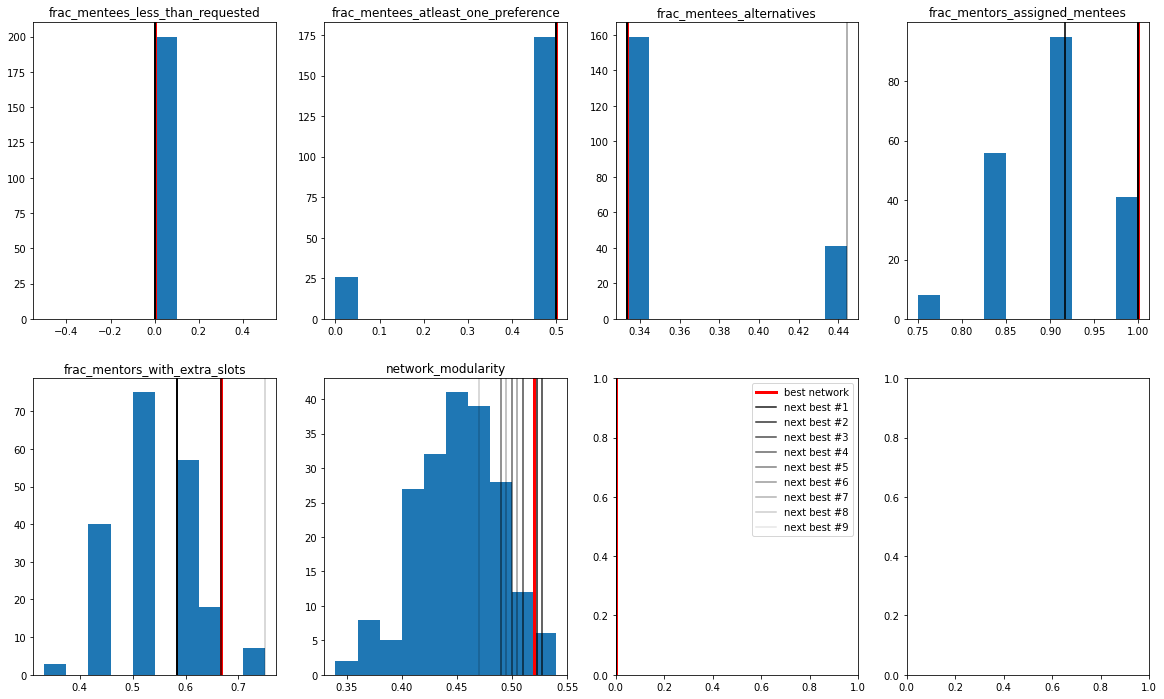

In [14]:
# plot all the metrics
nc = 4
nr = int(np.ceil(len(metrics)/nc))
fig,axs = plt.subplots(nr, nc, figsize = (20,12))
for i,ax in enumerate(axs.flatten()):
    if (i < len(metrics)):
        ax.hist(output['raw_metrics'][i], align = 'mid')
        ax.set_title(output['metric_names'][i])
        ax.axvline(output['raw_metrics'][i][output['best']['index']], color = 'red', lw = 3, label = 'best network')
        for ib in range(len(output['bestlist'])-1):
            ax.axvline(output['raw_metrics'][i][output['bestlist'][ib+1]['index']], color = 'black', lw = 1.5, alpha = (1.0-(ib+1)/10), label = 'next best #%d' %(ib+1))
    if i == len(metrics):
        ax.axvline(0, color = 'red', lw = 3, label = 'best network')
        for ib in range(len(output['bestlist'])-1):
            ax.axvline(0, color = 'black', lw = 1.5, alpha = (1.0-(ib+1)/10), label = 'next best #%d' %(ib+1))
        ax.legend()
        
print ("best network values:")
for i in range(len(metrics)):
    print(output['metric_names'][i], ':', output['raw_metrics'][i][output['best']['index']])

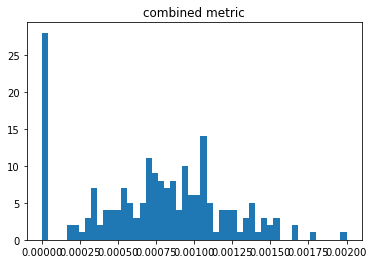

In [15]:
# plot the combined metric
f,ax = plt.subplots()
_ = ax.hist(output['combined_metric'], bins=50)
_ = ax.set_title('combined metric')

/Users/agurvich/Desktop/ExtraCurricular/CIERA/mentoring/network_analysis.py:140: RuntimeWarning: divide by zero encountered in double_scalars
  m2 = (p2b.y-p2a.y)/(p2b.x-p2a.x)
/Users/agurvich/Desktop/ExtraCurricular/CIERA/mentoring/network_analysis.py:139: RuntimeWarning: divide by zero encountered in double_scalars
  m1 = (p1b.y-p1a.y)/(p1b.x-p1a.x)
/Users/agurvich/Desktop/ExtraCurricular/CIERA/mentoring/network_analysis.py:180: RuntimeWarning: invalid value encountered in matmul
  xcross,ycross = np.matmul(np.linalg.pinv(mat),vec)[:,0]


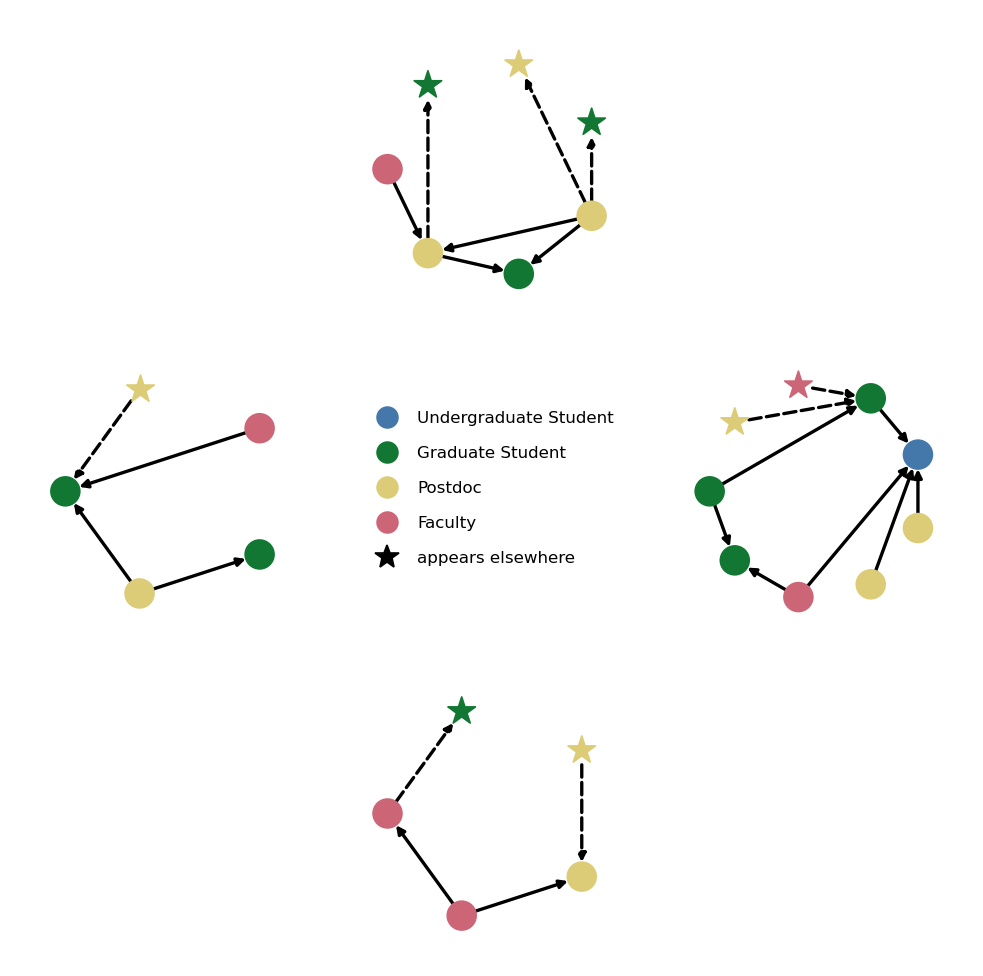

In [16]:
_ = draw_network(output['best']['network'])

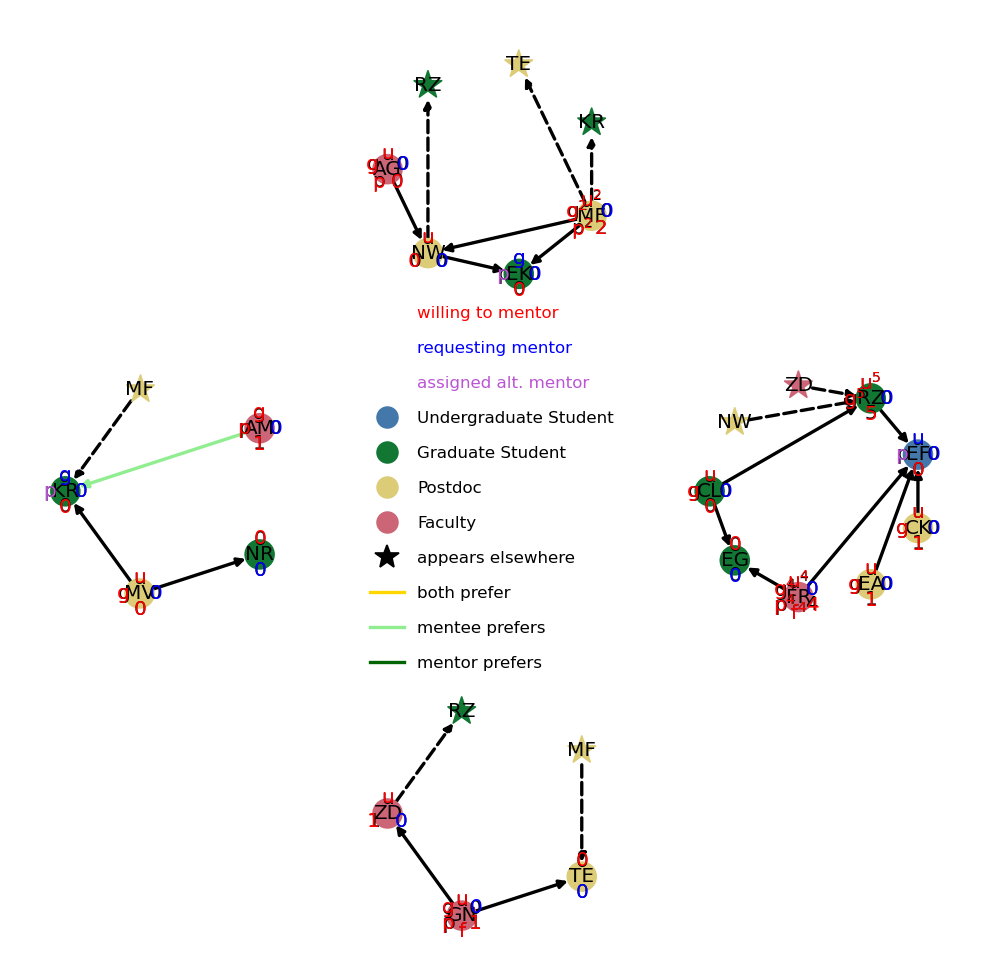

In [17]:
_ = draw_network(output['best']['network'],show_remaining_spots=True)

In [ ]:
from network_viz import list_matches

In [ ]:
matches = list_matches(output['best']['network'])

In [ ]:
matches

## Generate a file to use when creating emails

In [4]:
import json

In [ ]:
# generate a list of email dicts and save to a file
emails = generate_email_list(output['best']['network'])
with open('data/beta/emails.json', 'w', encoding='utf-8') as f:
    json.dump(emails, f, ensure_ascii=False, indent=4)

In [5]:
# read in the emails file and generate the emails
with open('data/beta/emails.json', 'r') as f:
    emails = json.load(f)
generate_automatic_outlook_emails(emails, N=2)

# Scratch space below ...

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import networkx as nx

In [ ]:
import pandas as pd

In [ ]:
from mentor_matching import reduce_full_tables

In [ ]:
names_df = pd.read_csv('data/alpha2/name_list.csv')
all_names = names_df.loc[:,::2].values.flatten()
for i in range(len(all_names)): 
    name = all_names[i]
    if type(name) == str:
        all_names[i] = name.replace(' ','')

## show just the first 5 rows
names_df.head()

In [ ]:
mentees_df = pd.read_csv('data/alpha2/mentees.csv')
#mentees_df.head()

In [ ]:
mentors_df = pd.read_csv('data/alpha2/mentors.csv')
#mentors_df.head()

In [ ]:
for person in people.values():
    if person.rank == 0:
        person.print_preferences()

--------

In [ ]:
from mentor_matching import generate_network
from network_metrics import *

In [ ]:
fig,axs = plt.subplots(nrows=2,ncols=5)
for i,ax in enumerate(axs.flatten()):
    if (i < len(vals)):
        ax.hist(vals[i], align = 'mid')
        ax.set_title(names[i])
fig.set_size_inches(26,8)

In [ ]:
vals.shape

In [ ]:
# testing a method to pick the best network
# in order of vals array
# 0: (top) maximize frac_mentees_with_a_mentor
# 1: maximize frac_mentees_less_than_requested
# 2: maximize frac_mentors_assigned_mentees ?
# 3: maximize frac_mentors_with_extra_slots ?
# 4: (top) throw out any with frac_mentors_overassigned --> required check
# 5: maximize frac_mentees_atleast_one_preference
# 6: (top) throw out any with frac_any_avoid > 0 --> required check
# 7: (top) maximize mean_clique_size
# 8: maximize n_cliques_gt
# 9: minmize alternative mentor assignments

combined_metric = [0]*nruns
topfac = 2.
midfac = 1.
#for normalizing the clique size
def norm_n_metric(val, arr):
    return (val - min(arr))/(max(arr) - min(arr))

for i in range(nruns):
    #top priority
    top = vals[0, i]*norm_n_metric(vals[7, i], vals[7])
    if (vals[4, i] > 0 or vals[6, i] > 0):
        top = 0
        
    #less important
    mid = vals[1,i]*vals[2,i]*vals[3,i]*vals[5,i]*norm_n_metric(vals[8,i], vals[8])
    
    #sum (note: this is some combined multiply and weighted average method...)
    combined_metric[i] = (topfac*top + midfac*mid)/(topfac + midfac)

#just a check
best = [i for (i, x) in enumerate(combined_metric) if x > 0.5]
print(best)
print(combined_metric[best[0]])
print('N with combined_metric > 0.7', len(best))
the_best = networks[best[0]]

In [ ]:
f, ax = plt.subplots()
_ = ax.hist(combined_metric)

In [ ]:
# testing a method to pick the best network
# in order of vals array
# 0: (top) maximize frac_mentees_with_a_mentor
# 1: maximize frac_mentees_less_than_requested
# 2: maximize frac_mentors_assigned_mentees ?
# 3: maximize frac_mentors_with_extra_slots ?
# 4: (top) throw out any with frac_mentors_overassigned --> required check
# 5: maximize frac_mentees_atleast_one_preference
# 6: (top) throw out any with frac_any_avoid > 0 --> required check
# 7: (top) maximize mean_clique_size
# 8: maximize n_cliques_gt
# 9: minmize alternative mentor assignments

from network_metrics import *

metrics = [
    {'function': run_frac_mentees_with_a_mentor,          'weight': 2, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentees_less_than_requested,    'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_assigned_mentees,       'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_with_extra_slots,       'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_mentors_overassigned,           'weight': 1, 'type':'binary0',  'normalize':False},
    {'function': run_frac_mentees_atleast_one_preference, 'weight': 1, 'type':'maximize', 'normalize':False},
    {'function': run_frac_any_avoid,                      'weight': 1, 'type':'binary0',  'normalize':False},
    {'function': run_mean_clique_size,                    'weight': 2, 'type':'maximize', 'normalize':True},
    {'function': run_n_cliques_gt2,                       'weight': 1, 'type':'maximize', 'normalize':True},
    {'function': run_frac_mentees_alternatives,           'weight': 1, 'type':'minimize', 'normalize':False},
]

multiply_metrics = run_weighted_metrics(people_list, network_list, metrics, method='multiply')
add_metrics = run_weighted_metrics(people_list, network_list, metrics, method='mean')

In [ ]:
nc = 5
nr = int(np.ceil(len(metrics)/nc))
fig,axs = plt.subplots(nrows = nr, ncols = nc)
for i,ax in enumerate(axs.flatten()):
    if (i < len(metrics)):
        ax.hist(multiply_metrics['raw_metrics'][i], align = 'mid')
        ax.set_title(multiply_metrics['metric_names'][i])
fig.set_size_inches(26,8)

In [ ]:
f, ax = plt.subplots(1, 2)
_ = ax[0].hist(multiply_metrics['combined_metric'])
_ = ax[1].hist(add_metrics['combined_metric'])